<h1>Reduce Manufacturing Failures</h1>

**Project Overview**

Manufacturing Failures System are to help manufacturing companies, has an imperative to ensure that the recipes for the production of its advanced mechanical components are of the highest quality and safety standards. Parts of doing so is closely monitoring its parts as they progress through the manufacturing processes. Because companies records data at every step along its assembly lines, they have the ability to apply advance analytics to improve these manufacturing processes. If the companies like Bosh use the manufacturing failures system it intimates the failure during the manufacturing process.
In this project, we will build a manufacturing failure systems to predict internal failures using thousands of measurements and tests made for each component along the assembly line. This would enable Bosh to bring quality products at lower costs to the end user.

**Problem Statement**

We got data which represents measurements of parts as they move through Bosh’s production lines. Each part has unique Id. The goal is to predict which parts will fail quality control (represented by a ‘Response’ = 1).
The dataset contains an extremely large number of anonymised features. Features are named according to a convention that tells you the production line, the station on the line, and a feature number. E.g. L3_S36_F3939 is a feature measured on line 3, station 36, and feature number 3939.
On account of the large size of the dataset, we have separated the files by the type of feature they contain: numerical, categorical, and finally, a file with date features. The date features provide a timestamp for when each measurement was taken. Each date column ends in a number that corresponds to the previous feature number. E.g. the value of L0_S0_D1 is the time at which L0_S0_F0 was taken.

File Descriptions:
•	train_numeric.csv - the training set numeric features (this file contains the 'Response' variable)
•	test_numeric.csv - the test set numeric features
•	train_categorical.csv - the training set categorical features.

For training the model we consider train_numeric which has the numeric features of each station. We got 1,183,000 numeric data for training, since the dataset is really large, we are not going to use all numeric for training.


In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import time
from IPython.display import display
from sklearn.metrics.classification import matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("muted")
%matplotlib inline

** Data Exploration**

The train numeric data is from train_numeric.csv. The dataset has 1183000 observations, 968 features and missing values which do not seem to be missing at random, the response we are playing with an imbalance ratio of 1:172(172 negatives for 1 positive) 99.4% accuracy.

In [12]:
train_numeric= pd.read_csv('train_numeric.csv', nrows=100000)
n_classes = train_numeric.shape[0]
passed = train_numeric[train_numeric['Response'] == 0].shape[0]
failed = train_numeric[train_numeric['Response'] == 1].shape[0]
grade = np.true_divide(passed, n_classes)*100
print("Number of passed: {}".format(passed))
print("Number of failed: {}".format(failed))
print("Percentage of passed: {:.2f}".format(grade))
train = train_numeric.drop(['Id', 'Response'], axis=1)
display(train.describe())

Number of passed: 99432
Number of failed: 568
Percentage of passed: 99.43


,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
count,57915.000000,57915.000000,57915.000000,57915.000000,57915.000000,57915.000000,57915.000000,57915.000000,57915.000000,57915.000000,...,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,5195.000000,5195.00000,5195.000000,5195.000000
mean,-0.001830,-0.002556,-0.000093,-0.000125,0.001020,0.003839,0.000335,0.002113,-0.001466,-0.000951,...,-0.005085,-0.000003,0.000014,0.000468,0.000153,0.002628,-0.000009,0.00039,0.000487,0.000063
std,0.080386,0.093103,0.211107,0.211272,0.093151,0.161776,0.019361,0.104126,0.115436,0.113312,...,0.152791,0.000055,0.000247,0.017878,0.001876,0.250033,0.000095,0.01962,0.012055,0.001176
min,-0.402000,-0.474000,-0.397000,-0.416000,-0.404000,-0.566000,-0.044000,-0.232000,-0.393000,-0.415000,...,-0.349000,-0.001000,0.000000,0.000000,0.000000,-0.250000,-0.001000,0.00000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,0.278000,0.280000,0.567000,0.566000,0.422000,0.388000,0.096000,0.528000,0.469000,0.537000,...,0.589000,0.000000,0.009000,0.900000,0.045000,0.250000,0.000000,1.00000,0.441000,0.046000


**Sorting out Lines, Stations, and Features**

The function below creates a two dicts that isolate all the features that belong to specific Lines and Stations. This makes it easy to slice the data on a Line-by-Line or Station-by-Station basis.

In [13]:
features = pd.read_csv('train_numeric.csv', nrows=1).drop(['Response', 'Id'], axis=1).columns.values

def orgainize(features):
    line_features = {}
    station_features = {}
    lines = set([f.split('_')[0] for f in features])
    stations = set([f.split('_')[1] for f in features])
    
    for l in lines:
        line_features[l] = [f for f in features if l+'_' in f]
        
    for s in stations:
        station_features[s] = [f for f in features if s+'_' in f]
        
            
    return line_features, station_features

line_features, station_features = orgainize(features)

**Exploring Stations**

Features - Total features in the Station

Samples - Total samples with measured values (non-NaN) >= 1 in the Station

Error rate - (Response==1) rate for samples in the Station.

Note* Samples run through multiple stations/lines, which was not taken into account, but may be important.

Note** A small percentage of samples have no data and were dropped.

In [14]:
station_error = []
for s in station_features:
    cols = ['Id', 'Response']
    cols.extend(station_features[s])
    df = pd.read_csv('train_numeric.csv', usecols=cols).dropna(subset=station_features[s], how='all')
    error_rate = df[df.Response == 1].size / float(df[df.Response == 0].size)
    station_error.append([df.shape[1]-2, df.shape[0], error_rate]) 
    
station_data = pd.DataFrame(station_error, 
                         columns=['Features', 'Samples', 'Error_Rate'], 
                         index=station_features).sort_index()
station_data

,Features,Samples,Error_Rate
S0,12,673862,0.005383
S1,2,673904,0.005380
S10,12,224540,0.005477
S11,12,225452,0.005320
S12,12,242061,0.005496
S13,2,242065,0.005496
S14,9,120625,0.005678
S15,9,121445,0.005298
S16,2,119139,0.005579
S17,2,123027,0.005410


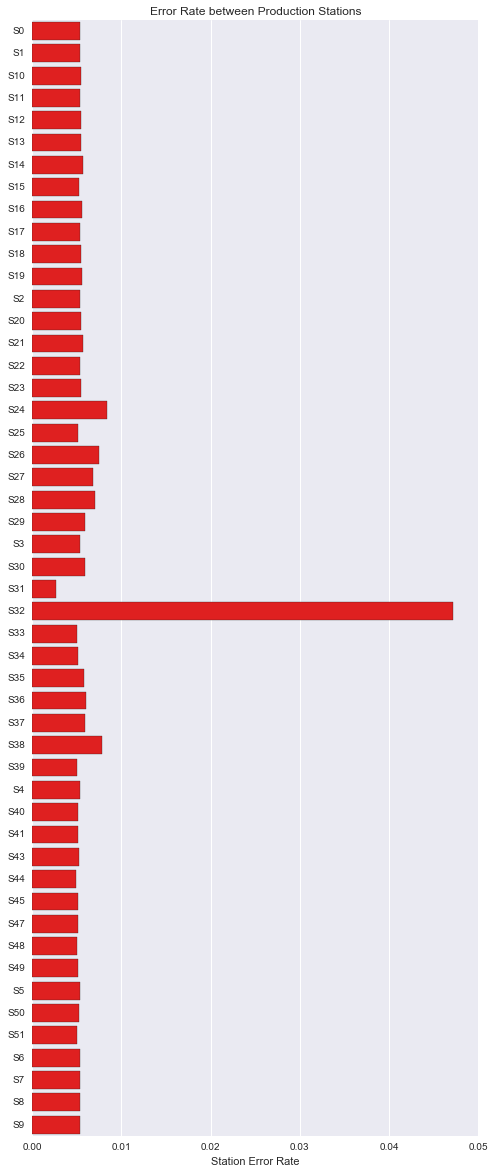

In [15]:
plt.figure(figsize=(8, 20))
sns.barplot(x='Error_Rate', y=station_data.index.values, data=station_data, color="red")
plt.title('Error Rate between Production Stations')

plt.xlabel('Station Error Rate')
plt.show()

**Metrics**

We need to estimate the parts which will fail quality control represented by a Response = 1.
The evaluation for this task is Matthews correlation coefficient (MCC) between the predicted and the observed response. 


In [2]:
def predict_labels(clf, features, target):
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print("Trained model in {:.4f} seconds".format(end - start))
    return matthews_corrcoef(target.values, y_pred)

**Result**

**Model Evaluation and Visualization**

To demonstrate the result of a final model at the parameter setting n_estimators = 518 and max_features = 450, I consider running the code at 3 different sizes of the dataset.

The Extratree Classification model is trained by three different size of training sets and tested using the three different size testing set, which are then evaluated using Matthews Correlation Coefficient (MCC) between the predicted and the observed response.

(100000, 968)
Spliting Data......
predicting data...........
216.151000023
Trained model in 1.1910 seconds
Tuned model has a training MCC score of 0.9468.
Trained model in 0.8550 seconds
Tuned model has a testing MCC score of 0.1270.
(250000, 968)
Spliting Data......
predicting data...........
765.976000071
Trained model in 3.7640 seconds
Tuned model has a training MCC score of 0.9520.
Trained model in 1.3800 seconds
Tuned model has a testing MCC score of 0.1800.
(500000, 968)
Spliting Data......
predicting data...........
2020.18000007
Trained model in 8.9890 seconds
Tuned model has a training MCC score of 0.9500.
Trained model in 3.9420 seconds
Tuned model has a testing MCC score of 0.1825.


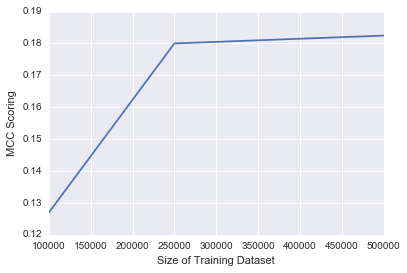

In [3]:
nrows = [100000, 250000, 500000]
score_1 = []
for n in nrows:
    train_numeric= pd.read_csv('train_numeric.csv', nrows=n)
    train = train_numeric.drop(['Id', 'Response'], axis=1)
    y = train_numeric['Response']
    train.fillna(-9, inplace=True)
    print(train.shape)
    print("Spliting Data......")
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.30, random_state = 98, stratify = y)
    print("predicting data...........")
    start = time.time()
    clf = ExtraTreesClassifier(n_estimators=518,max_features=450,n_jobs=-1,warm_start=True).fit(X_train, y_train)
    end = time.time()
    print(end - start)
    print "Tuned model has a training MCC score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
    score = predict_labels(clf, X_test, y_test)
    score_1.append(score)
    print "Tuned model has a testing MCC score of {:.4f}.".format(score)
    
plt.plot(nrows, score_1)
plt.xlabel('Size of Training Dataset')
plt.ylabel('MCC Scoring')
plt.show()

When the classifier is trained by 70,000 data and tested using 30,000 data the MCC score is 0.1796 which seems to be better performing which compared baseline score the model makes good performance improvement.

Now the model is trained by 350,000 data and tested using 150,000 data the MCC score is 0.1708 which is not a good improvement with respect to the 70,000 test data.

Finally when the model is trained without changing the parameters by 560,000 data and tested by 240,000 data now the MCC score make a sudden jump to 0.1909.

According to the analysis of MCC score as the model is trained by large dataset the performance increases. When the model is trained further the model’s performance may increase.

**Conclution**

**Reflection**

This project is to reduce manufacturing failures, we are given 1183000 Bosh manufacturing dataset which has the numerical record of the tools at each station. Most of the time is spent on understanding the data and handle the missing values, where the numerical values are in the range -1 to 1, where the missing value is handled by replacing with -9 which helped in model prediction.

Another interesting thing of the dataset is the importance of features for prediction. As mentioned in analysis few station has high error rate particularly station 32 has 4.7% error rate by viewing 25,000 datasets but as we increase the analysis of the dataset the error rate keeps changing with the station, this analyzation shows the equal importance of  features. Thus training the model with 46% of the features would help in predicting the manufacturing failure.

Based on the baseline score Extratree Classification model performance best in baseline without tuning the parameters scoring 0.0926. The tuning parameters for extratree classification are n_estimators, max_features, max_depth, min_samples_split and min_samples_leaf, where max_features helps in controls over-fitting the model. Tuning the max_features with 150, 250 and 450, when max_features at 150 and 250 the model performance score is not at big improvement from baseline score, but when max_features is at 450 the performance of the model is notably increasing. While introducing max_depth, min_samples_split and min_samples_leaf the model gets under-fitting. Thus for final prediction the parameters n_estimators and max_features are set to 518 and 450, which make the scoring of 0.1909 by training with 560,000 data.

**Improvement**

The first and most obvious way to improve this model is to start taking in more data. I only made use of Bosh manufacturing reading of each station provided in kaggle, by training the model with large dataset may improve prediction model. Some cleaning would have to be done by normalising or feature selecting by looking the large data.

It’s also possible that Extratree classification model isn’t the right way for the dataset and in reality, the metrics of using accuracy may not be a good idea in practice, we should consider assigning additional weight to negative instances, for example, F_1 score.
